# BTSnoop Log Sniffer

This notebook demonstrates the process of parsing bluetooth packet data from android hci logs.

In [57]:
# !pip install fpdf
# !pip install kaleido
# !pip install dataframe_image

In [1]:
import fpdf
from fpdf import FPDF
import dataframe_image as dfi
import matplotlib.pyplot as plt
import time

import json
import pandas as pd
from pprint import pprint

pd.set_option('display.max_columns', None)

# TODO: SQLite storage for known devices

[source](https://github.com/nccgroup/BLE-Replay/blob/master/btsnoop/btsnoop/bt/hci_evt.py)

The HCI LE Meta Event is used to encapsulate all LE Controller specific events.
The Event Code of all LE Meta Events shall be 0x3E. The Subevent_Code is
the first octet of the event parameters. The Subevent_Code shall be set to one
of the valid Subevent_Codes from an LE specific event


HCI inherently cannot differentiate between packet types. Hence a common physical interface is used with the indicators that are sent right before the packet is sent. These indicators are as follows

| HCI Packet Type | HCI Packet Indicator |
| --------------- | -------------------- |
| HCI Command Packet | 0x01 |
| HCI ACL Data Packet | 0x02 |
| HCI Synchronous Data Packet | 0x03 |
| HCI Event Packet | 0x04 |
| HCI ISO Data Packet | 0x05 |

LE Meta events encapsulate all LE Controller events and have a code of 0x03

protocols = {
    "bluetooth:hci_h4:bthci_acl:btl2cap": 'ACL-L2CAP Event',
    "bluetooth:hci_h4:bthci_acl:btl2cap:btatt": 'ACL-L2CAP - ATT (Attribute) Protocol',
    "bluetooth:hci_h4:bthci_acl:btl2cap:btavctp:btavrcp": 'ACL-L2CAP - AVCTP/AVR Protocol',
    "bluetooth:hci_h4:bthci_acl:btl2cap:btavdtp": 'ACL-L2CAP - AVDTP Protocol',
    "bluetooth:hci_h4:bthci_acl:btl2cap:btrfcomm": 'ACL-L2CAP - RF Communication protocol',
    "bluetooth:hci_h4:bthci_acl:btl2cap:btrfcomm:bthfp": 'ACL-L2CAP - Hands Free Protocol',
    "bluetooth:hci_h4:bthci_acl:btl2cap:btrfcomm:data": 'ACL-L2CAP - Data Transfer',
    "bluetooth:hci_h4:bthci_acl:btl2cap:btsdp": 'ACL-L2CAP - Service Discovery Protocol (SDP)',
    "bluetooth:hci_h4:bthci_cmd": 'HCI Command',
    "bluetooth:hci_h4:bthci_cmd:btcommon": 'Bluetooth Advertising Event',
    "bluetooth:hci_h4:bthci_cmd:bthci_vendor.broadcom": 'Vendor-Specific Broadcom Packet',
    "bluetooth:hci_h4:bthci_evt": 'HCI Event',
    "bluetooth:hci_h4:bthci_evt:btcommon": 'Bluetooth Advertising Event',
    "bluetooth:hci_h4:bthci_evt:bthci_vendor.broadcom": 'Vendor-Specific Broadcom Packet'
    }

hci_le_event = {
    '0x01': 'Bluetooth HCI Command',
    '0x02': 'Bluetooth HCI ACL',
    '0x04': 'Bluetooth HCI Event'
}

In [ ]:
with open('./output1.json', 'r') as file:
    data = [x["_source"]["layers"] for x in json.load(file)]

# HCI_CMD Direction h -> c 0x00
# HCI_EVT Direction h -> c 0x00

# Event has CMD in frame to point to command

hci_le_event = {
    '0x01': 'Bluetooth HCI Command (HCI_CMD)',
    '0x02': 'Bluetooth HCI ACL (HCI_ACL)',
    '0x04': 'Bluetooth HCI Event (HCI_EVT)'
}

event_direction = {
    '0x00':'Host > Controller',
    '0x01': 'Controller > Host'
}

for packet in data:
    packet["Sequence Number"] = packet["frame.number"][0] if "frame.number" in packet else None
    packet["Packet Length"] = packet["frame.len"][0] if "frame.len" in packet else None
    packet["UTC Timestamp"] = packet["frame.time_utc"][0] if "frame.time_utc" in packet else None
    packet["Protocol"] = packet["frame.protocols"][0] if "frame.protocols" in packet else None
    packet["Event Type"] = hci_le_event[packet["frame.number"][0]] if "frame.number" in packet else None
    packet["Direction"] = event_direction[packet["hci_h4.direction"][0]] if "hci_h4.direction" in packet else None
    packet["Opcode"] = packet["bthci_cmd.opcode"][0] if "bthci_cmd.opcode" in packet else (packet["bthci_evt.opcode"][0] if "bthci_evt.opcode" in packet else None)
    packet["sequence_number"] = packet["frame.number"][0] if "frame.number" in packet else None
    packet["sequence_number"] = packet["frame.number"][0] if "frame.number" in packet else None
    packet["sequence_number"] = packet["frame.number"][0] if "frame.number" in packet else None




In [3]:
pprint(data[0])

{'Epoch Time': '1727925135.575141000',
 'Protocol': 'bluetooth:hci_h4:bthci_cmd',
 'bthci_cmd': ['Bluetooth HCI Command - Reset'],
 'bthci_cmd.opcode': ['0x0c03'],
 'frame.len': ['4'],
 'frame.number': ['1'],
 'frame.protocols': ['bluetooth:hci_h4:bthci_cmd'],
 'frame.time_epoch': ['1727925135.575141000'],
 'hci_h4.direction': ['0x00'],
 'hci_h4.type': ['0x01'],
 'packet_length': '4',
 'sequence_number': '1'}


In [60]:
unique_protocols = set(packet['btatt.opcode'] for packet in data)
pprint(unique_protocols)

KeyError: 'btatt.opcode'

The Bluetooth Asynchronous Connection-oriented Logical transport (ACL) is a method of transfer of asynchronous (data that is not in real time) data over a bluetooth connection.

Looking at some of the profiles under ACL we see the following:

- *AVDTP*: This is the Audio/Video Distribution Transport Protocol (AVDTP) signifies the streaming of music to a bluetooth speaker device such as a set of headsets over the L2CAP protocol.
- *HFP*: The hands free profile (HFP) can be seen as a mode of remote control between the phone and bluetooth device.
- *AVRCP*: The Audio/Video Remote Control Profile is used along with the A2DP (Advanced Audio Distribution Profile) profile to allow a single remote device to control a bluetooth device
- *SDP*: The Service Discovert Protocol is a manner of communication to discover the available bluetooth devices nearby and their types.

[Reference](https://datatracker.ietf.org/doc/html/rfc1761)

Android bluetooth logs come in the **Snoop Version 1 Packet Capture File Format** which is similar to the second version developed by Sun Microsystems in 1995. When we capture logs of this format, we obtain arrays of octets (8 bit packets of information), with each array item corresponding to a packet record.


In [ ]:
ble_data[ble_data['hci_packet_type'] == 'HCI_EVT'].dropna(axis=1, how='all').head()

,sequence_number,packet_length,time_rcvd,packet_source,packet_destination,hci_packet_type,hci_packet_code,packet_data_unparsed
1,2,7,2024-10-03 03:12:15.580693,Controller,Host,HCI_EVT,4,b'\x04\x0e\x04\x01\x03\x0c\x00'
3,4,7,2024-10-03 03:12:15.581154,Controller,Host,HCI_EVT,4,b'\x04\x0e\x04\x01\x01\x0c\x00'
5,6,7,2024-10-03 03:12:15.581538,Controller,Host,HCI_EVT,4,b'\x04\x0e\x04\x01m\x0c\x00'
7,8,255,2024-10-03 03:12:15.582516,Controller,Host,HCI_EVT,4,b'\x04\x0e\xfc\x01\x14\x0c\x00BCM4389C1 ES1PX_...
9,10,15,2024-10-03 03:12:15.582924,Controller,Host,HCI_EVT,4,b'\x04\x0e\x0c\x01\x01\x10\x00\x0b\xcb \x0b\x0...


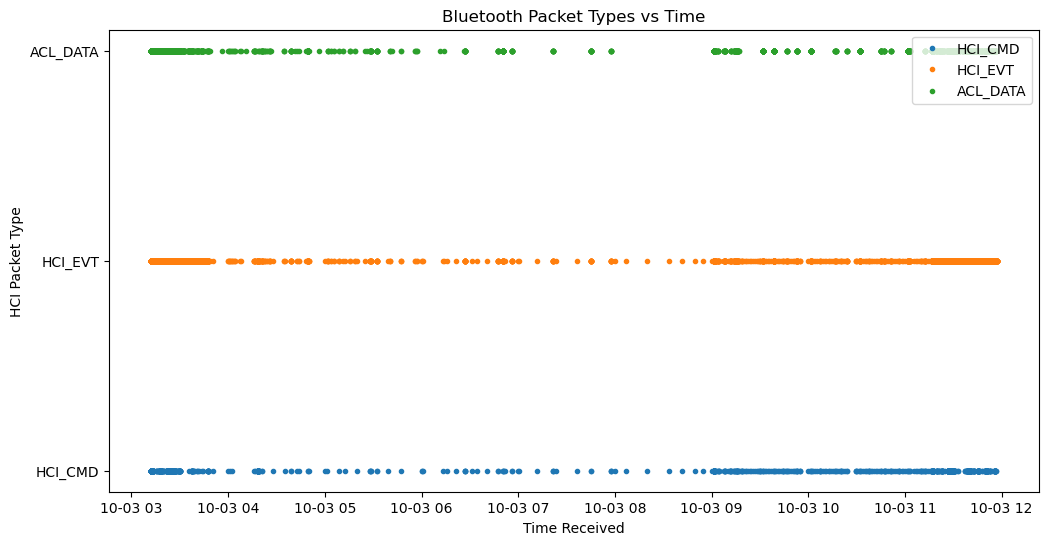

In [ ]:
ble_data['time_rcvd'] = pd.to_datetime(ble_data['time_rcvd'])

plt.figure(figsize=(12, 6))
for pkt_type in ble_data['hci_packet_type'].unique():
    subset = ble_data[ble_data['hci_packet_type'] == pkt_type]
    plt.plot(subset['time_rcvd'], subset['hci_packet_type'], '.', label=pkt_type)

plt.xlabel('Time Received')
plt.ylabel('HCI Packet Type')
plt.title('Bluetooth Packet Types vs Time')
plt.legend(loc='upper right')
plt.show()

The package used here cannot get MAC addresses and device names. TShark command

```bash
sudo tshark -r ./src/bt_logfiles/btsnoop_hci_27102024_1341.log -Y "btcommon.eir_ad.entry.device_name" -T fields -e frame.time -e bluetooth.device_name -e bluetooth.addr >> ./src/outputs/output4.txt

sudo tshark -r ./src/bt_logfiles/btsnoop_hci_27102024_1341.log -Y "btcommon.eir_ad.entry.device_name" -T fields -e frame.time -e btcommon.eir_ad.entry.device_name -e bluetooth.addr > ./src/outputs/output3.txt
```